# SurvSHAP vs DeepLift vs Integrated Gradients
### J. Krajewski, S. Frejlak, M. Wojtala

### Experiment 1: evaluation on artificial data

#### Imports

In [1]:
# This code is useful if you want to make changes in any of the imported libraries, e.g. to solve compatibility issues.
%load_ext autoreload
%autoreload 2

In [2]:
!pip3 install torchtuples
!pip3 install pycox

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy.integrate import trapezoid
from typing import List
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sksurv.functions import StepFunction

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle

from survshap import SurvivalModelExplainer, ModelSurvSHAP, PredictSurvSHAP
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
)

import quantus

from pycox.evaluation import EvalSurv
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jpeg"

# os.environ["CUDA_VISIBLE_DEVICES"]=""

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Helper classes and functions

In [3]:
class ColumnNotPresentError(Exception):
    def __init__(self, ke, column_name_parameter, column_names):
        self.message = f"'{ke.__str__}' not present in dataframe columns. Please, specify the correct column name(s) as parameter(s) {column_name_parameter}. Available options: {', '.join(list(column_names))}"
        super().__init__(self.message)


def train_val_test_split(dataframe_raw, verbose=True, time_column='time'):
    dataframe_test = dataframe_raw.sample(frac=0.2)
    dataframe_train = dataframe_raw.drop(dataframe_test.index)
    dataframe_val = dataframe_train.sample(frac=0.2)
    dataframe_train = dataframe_train.drop(dataframe_val.index)
    if verbose:
        print(dataframe_raw.head())
        try:
            print(f"Min time: {dataframe_raw[time_column].min():.4g} Max time: {dataframe_raw[time_column].max():.4g} Average time: {dataframe_raw[time_column].mean():.4g}")
        except KeyError as ke:
            raise ColumnNotPresentError(ke, 'time_column', dataframe_raw.columns)
    return dataframe_train, dataframe_test, dataframe_val

def standardize_mapper(to_standardize, to_leave):
    standardize = [([col], StandardScaler()) for col in to_standardize]
    leave = [(col, None) for col in to_leave]

    return DataFrameMapper(standardize + leave)

In [4]:
def prepare_x_y(dataframe_split: List[pd.DataFrame], to_stadardize, to_leave, num_durations, time_column='time',
                event_column='event'):
    """Provide a dataframe with the training set as the first one in the list dataframe_split"""
    x_mapper = standardize_mapper(cols_standardize, cols_leave)
    label_transform = DeepHitSingle.label_transform(num_durations)
    df_first = dataframe_split[0]

    try:
        get_target = lambda df: (df[time_column].values, df[event_column].values)

        x_list = [x_mapper.fit_transform(df_first).astype('float32')]
        y_list = [label_transform.fit_transform(*get_target(df_first))]
        for df_next in dataframe_split[1:]:
            x_list.append(x_mapper.transform(df_next).astype('float32'))
            y_list.append(label_transform.transform(*get_target(df_next)))
    except KeyError as ke:
        raise ColumnNotPresentError(ke, 'time_column, event_column', df_first.columns)
    return zip(x_list, y_list), label_transform

In [5]:
def compute_single_attributions_and_metrics(net, example, explainer, inputs, outputs, num_durations, metrics, verbose=False):
    inputs_torch = torch.tensor(inputs, requires_grad=True).cuda()
    outputs_torch = torch.tensor(outputs[1].astype('int64')).cuda()
    ig = explainer(net)
    baseline = torch.mean(inputs_torch, dim=0).unsqueeze(dim=0).expand([num_durations, -1]) #.expand(inputs.shape)
    single_input = inputs_torch[example, :].unsqueeze(dim=0).expand([num_durations, -1])
    attributions = ig.attribute(single_input, target=torch.tensor(range(num_durations)).cuda(), baselines=baseline)
    attributions = pd.DataFrame(attributions.detach().cpu().numpy(), index=range(num_durations), columns=cols_leave + cols_standardize)
    if verbose:
        px.line(attributions, color="variable", line_shape="hv").show()

    input_np = single_input.detach().cpu().numpy() # np.full([inputs.shape[1], num_durations], inputs[example]).astype(np.int64)
    output_np = np.full([num_durations], outputs[1][example]).astype(np.int64)
    metric_scores = []
    for metric in metrics:
        scores = metric(
            model=net,
            x_batch=input_np,
            y_batch=output_np,
            a_batch=attributions.values,
            device=DEVICE,
            explain_func=quantus.explain,
            explain_func_kwargs={"method": "IntegratedGradients"}
        )
        # print(input_np.shape)
        # print(scores)
        # print(attributions.values.shape)
        scores = pd.DataFrame(data=scores, index=range(num_durations))
        if verbose:
            plt.plot(scores)
        metric_scores.append(scores)
    return attributions, metric_scores


def compute_attributions_and_metrics(net, explainer, inputs, outputs, num_durations, metrics):
    num_examples = inputs.shape[0]
    num_features = inputs.shape[1]
    aggregated_attributions = np.empty([num_examples, num_durations, num_features])
    aggregated_metric_scores = [np.empty([num_examples, num_durations]) * len(metrics)]
    for i in range(num_examples): #, desc='Computing attributions and metrics'):
        attributions, metric_scores = compute_single_attributions_and_metrics(net, i, explainer, inputs, outputs, num_durations, metrics)
        aggregated_attributions[i] = attributions
        for ams, ms in zip(aggregated_metric_scores, metric_scores):
            ams[i] = ms.squeeze()
    return aggregated_attributions, aggregated_metric_scores

In [6]:
# define colors as a list
colors = px.colors.qualitative.Plotly

# convert plotly hex colors to rgba to enable transparency adjustments
def hex_rgba(hex, transparency):
    col_hex = hex.lstrip('#')
    col_rgb = list(int(col_hex[i:i+2], 16) for i in (0, 2, 4))
    col_rgb.extend([transparency])
    areacol = tuple(col_rgb)
    return areacol

rgba = [hex_rgba(c, transparency=0.2) for c in colors]
colCycle = ['rgba'+str(elem) for elem in rgba]

# Make sure the colors run in cycles if there are more lines than colors
def next_col(cols):
    while True:
        for col in cols:
            yield col

line_color = next_col(colCycle)

In [7]:
avg_sensitivity = quantus.AvgSensitivity(nr_samples=10,
                                         lower_bound=0.2,
                                         norm_numerator=quantus.norm_func.fro_norm,
                                         norm_denominator=quantus.norm_func.fro_norm,
                                         perturb_func=quantus.perturb_func.uniform_noise,
                                         similarity_func=quantus.similarity_func.difference,
                                         disable_warnings=True,
                                         # perturb_func_kwargs={'indices': [2, 3, 4]}
                                         )

faithfulness_corr = quantus.FaithfulnessCorrelation(subset_size=2,
                                                    similarity_func=(lambda a, b: quantus.similarity_func.difference(np.array(a),
                                                                                                                     np.array(b))),
                                                    perturb_func=quantus.perturb_func.uniform_noise)
used_metrics = [avg_sensitivity] #, faithfulness_corr]
metrics_names = ['Avg Sensitivity']#, 'Faithfulness Corr']

Warnings and information:
 (1) The Faithfulness Correlation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', size of subset |S| 'subset_size' and the number of runs (for each input and explanation pair) 'nr_runs'.  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Bhatt, Umang, Adrian Weller, and José MF Moura. 'Evaluating and aggregating feature-based model explanations.' arXiv preprint arXiv:2005.00631 (2020).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



### Experiment 1: Artificial data

In [8]:
df_raw = pd.read_csv('data/exp1_data_complex.csv')

df_train, df_val, df_test = train_val_test_split(df_raw)

   x1  x2         x3         x4        x5       time  event
0   0   0  12.559994   8.810540 -0.335024   1.371523      0
1   1   1   7.848031  24.935806 -0.815996   1.031760      0
2   0   0   9.851197  20.999098 -0.107522  13.387439      0
3   1   0  10.398557  12.633733 -1.129195   7.879721      0
4   0   1   7.082080  20.895630  0.605936   1.939003      1
Min time: 0.0126 Max time: 14.68 Average time: 5.425


In [9]:
cols_standardize = ['x3', 'x4', 'x5']
cols_leave = ['x1', 'x2']
num_durations = 20

(train, val, test), labtrans = prepare_x_y([df_train, df_val, df_test], cols_standardize, cols_leave, num_durations)
x_train, y_train = train
x_val, y_val = val
x_test, y_test = test

In [10]:
in_features = x_train.shape[1]
num_nodes = [4, 4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle(net, tt.optim.Adam(0.0001), duration_index=labtrans.cuts)


0:	[1s / 1s],		train_loss: 0.7566,	val_loss: 0.7015
1:	[0s / 1s],		train_loss: 0.7604,	val_loss: 0.7043
2:	[0s / 1s],		train_loss: 0.7606,	val_loss: 0.7090
3:	[0s / 1s],		train_loss: 0.7586,	val_loss: 0.7150
4:	[0s / 1s],		train_loss: 0.7567,	val_loss: 0.7207
5:	[0s / 1s],		train_loss: 0.7548,	val_loss: 0.7255
6:	[0s / 1s],		train_loss: 0.7588,	val_loss: 0.7285
7:	[0s / 1s],		train_loss: 0.7553,	val_loss: 0.7306
8:	[0s / 1s],		train_loss: 0.7546,	val_loss: 0.7320
9:	[0s / 1s],		train_loss: 0.7530,	val_loss: 0.7326
10:	[0s / 1s],		train_loss: 0.7556,	val_loss: 0.7326
11:	[0s / 1s],		train_loss: 0.7558,	val_loss: 0.7325
12:	[0s / 1s],		train_loss: 0.7534,	val_loss: 0.7320
13:	[0s / 1s],		train_loss: 0.7538,	val_loss: 0.7319
14:	[0s / 1s],		train_loss: 0.7543,	val_loss: 0.7313
15:	[0s / 1s],		train_loss: 0.7533,	val_loss: 0.7309
16:	[0s / 1s],		train_loss: 0.7500,	val_loss: 0.7306
17:	[0s / 2s],		train_loss: 0.7546,	val_loss: 0.7300
18:	[0s / 2s],		train_loss: 0.7536,	val_loss: 0.7296
19:

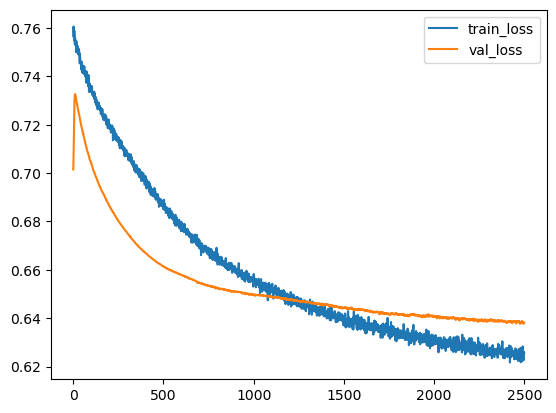

In [11]:
batch_size = 128
epochs = 2500
callbacks = []  # [tt.cb.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)
_ = log.plot()

In [12]:
aggregated_attributions, aggregated_metric_scores =  compute_attributions_and_metrics(model.net, IntegratedGradients, x_train, y_train, num_durations, used_metrics)

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing inp

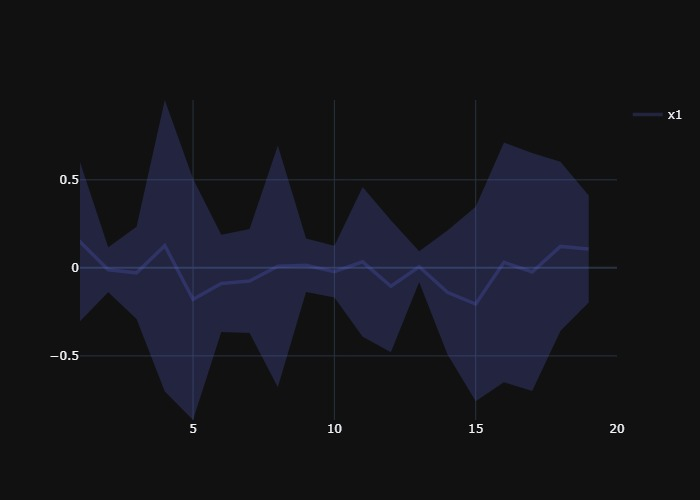

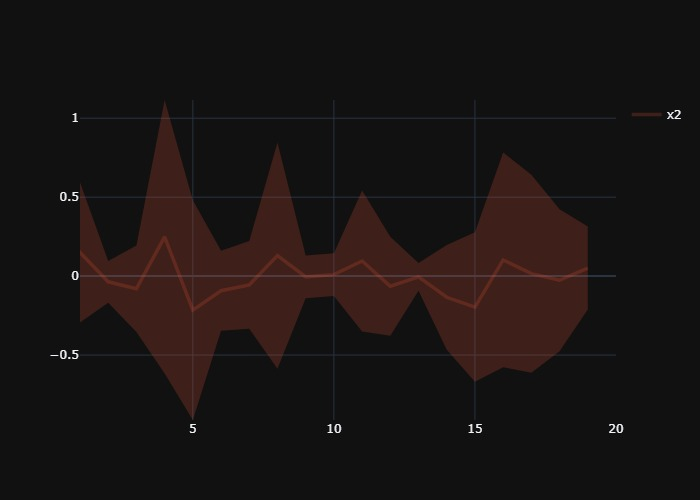

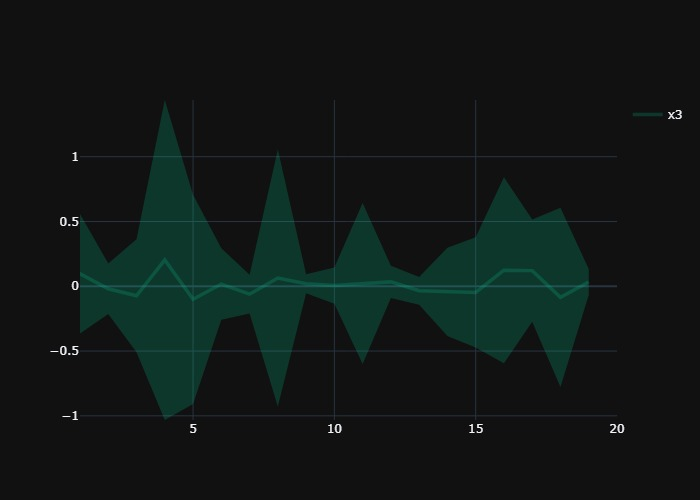

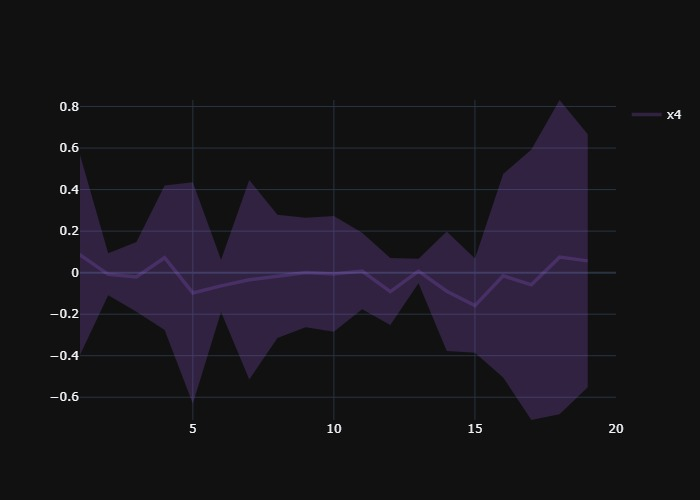

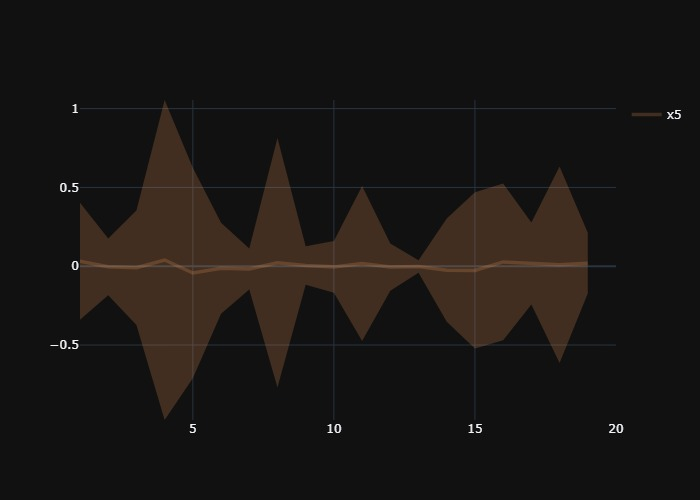

In [13]:
model.eval()

x = list(range(num_durations))
num_features = x_train.shape[1]

for i in range(num_features):
    fig = go.Figure()
    new_col = next(line_color)

    y_means = np.apply_along_axis(lambda feature: feature.mean(), axis=0, arr=aggregated_attributions[:, :, i])
    y_stds = np.apply_along_axis(lambda feature: feature.std(), axis=0, arr=aggregated_attributions[:, :, i])
    y_lows = [y for y in y_means - y_stds]
    y_lows = y_lows[::-1]
    y_ups = [y for y in y_means + y_stds]

    # standard deviation area
    fig.add_traces(go.Scatter(x=x+x[::-1],
                              y=y_ups+y_lows,
                              fill='tozerox',
                              fillcolor=new_col,
                              line=dict(color='rgba(255,255,255,0)'),
                              showlegend=False,
                              name=df_train.columns[i]))

    # line trace
    fig.add_traces(go.Scatter(x=x,
                              y=y_means,
                              line=dict(color=new_col, width=3.5),
                              mode='lines',
                              name=df_train.columns[i])
                   )

    # set x-axis
    fig.update_layout(xaxis=dict(range=[1,num_durations]))

    fig.show()

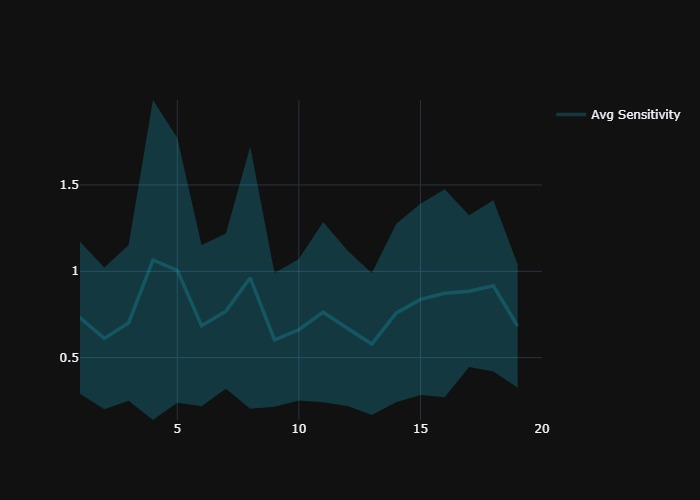

In [14]:
for ams, m_name in zip(aggregated_metric_scores, metrics_names):
    fig = go.Figure()
    new_col = next(line_color)

    y_means = np.apply_along_axis(lambda feature: feature.mean(), axis=0, arr=ams)
    y_stds = np.apply_along_axis(lambda feature: feature.std(), axis=0, arr=ams)
    y_lows = [y for y in y_means - y_stds]
    y_lows = y_lows[::-1]
    # attributions_ups[i] \
    y_ups = [y for y in y_means + y_stds]
    # y1_upper = [(y + np.std(df[col])) for y in df[col]]
    # y1_lower = [(y - np.std(df[col])) for y in df[col]]
    # y1_lower = y1_lower[::-1]

    # standard deviation area
    fig.add_traces(go.Scatter(x=x+x[::-1],
                              y=y_ups+y_lows,
                              fill='tozerox',
                              fillcolor=new_col,
                              line=dict(color='rgba(255,255,255,0)'),
                              showlegend=False,
                              name=m_name)
                   )

    # line trace
    fig.add_traces(go.Scatter(x=x,
                              y=y_means,
                              line=dict(color=new_col, width=3.5),
                              mode='lines',
                              name=m_name)
                   )

    # set x-axis
    fig.update_layout(xaxis=dict(range=[1,num_durations]))

    fig.show()

### Experiment 2: Real-world use case: predicting survival of patients with heart failure

#### Preparing data and deep model

In [15]:
df_raw = pd.read_csv('data/exp3_heart_failure_dataset.csv')

df_train, df_val, df_test = train_val_test_split(df_raw)

    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0  210000.00               1.9           137    1   
4                    0  327000.00               2.7           116    0   

   smoking  time  DEATH_EVENT  
0        0     4            1  
1        0     6            1  
2       

In [24]:
cols_standardize = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
cols_leave = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
num_durations = 50

(train, val, test), labtrans = prepare_x_y([df_train, df_val, df_test], cols_standardize, cols_leave, num_durations, event_column='DEATH_EVENT')
x_train, y_train = train
x_val, y_val = val
x_test, y_test = test

#### Training deep model

In [25]:
in_features = x_train.shape[1]
num_nodes = [4, 4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)
model = DeepHitSingle(net, tt.optim.Adam(0.0001), duration_index=labtrans.cuts)

batch_size = 64
epochs = 1000
callbacks = []# [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.6206,	val_loss: 0.6554
1:	[0s / 0s],		train_loss: 0.6144,	val_loss: 0.6555
2:	[0s / 0s],		train_loss: 0.6189,	val_loss: 0.6564
3:	[0s / 0s],		train_loss: 0.6366,	val_loss: 0.6588
4:	[0s / 0s],		train_loss: 0.6059,	val_loss: 0.6624
5:	[0s / 0s],		train_loss: 0.6186,	val_loss: 0.6666
6:	[0s / 0s],		train_loss: 0.6237,	val_loss: 0.6719
7:	[0s / 0s],		train_loss: 0.6118,	val_loss: 0.6774
8:	[0s / 0s],		train_loss: 0.6151,	val_loss: 0.6818
9:	[0s / 0s],		train_loss: 0.6140,	val_loss: 0.6862
10:	[0s / 0s],		train_loss: 0.6113,	val_loss: 0.6905
11:	[0s / 0s],		train_loss: 0.6294,	val_loss: 0.6943
12:	[0s / 0s],		train_loss: 0.6045,	val_loss: 0.6952
13:	[0s / 0s],		train_loss: 0.6104,	val_loss: 0.6976
14:	[0s / 0s],		train_loss: 0.6259,	val_loss: 0.7008
15:	[0s / 0s],		train_loss: 0.6121,	val_loss: 0.7003
16:	[0s / 0s],		train_loss: 0.6237,	val_loss: 0.6992
17:	[0s / 0s],		train_loss: 0.6252,	val_loss: 0.6992
18:	[0s / 0s],		train_loss: 0.6139,	val_loss: 0.6983
19:

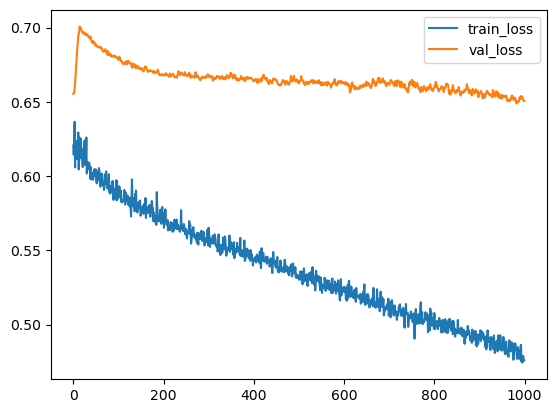

In [26]:
_ = log.plot()

In [27]:
aggregated_attributions, aggregated_metric_scores =  compute_attributions_and_metrics(model.net, IntegratedGradients, x_train, y_train, num_durations, used_metrics)

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.

C:\Users\StanislawFrejlak\anaconda3\Lib\site-packages\quantus\helpers\warn.py:262: UserWarning:

The settings for perturbing inp

AssertionError: The elements in the attribution vector are all equal to zero, which may cause inconsistent results since many metrics rely on ordering. Recompute the explanations.

In [ ]:
model.eval()

x = list(range(num_durations))
num_features = x_train.shape[1]

for i in range(num_features):
    fig = go.Figure()
    new_col = next(line_color)

    y_means = np.apply_along_axis(lambda feature: feature.mean(), axis=0, arr=aggregated_attributions[:, :, i])
    y_stds = np.apply_along_axis(lambda feature: feature.std(), axis=0, arr=aggregated_attributions[:, :, i])
    y_lows = [y for y in y_means - y_stds]
    y_lows = y_lows[::-1]
    y_ups = [y for y in y_means + y_stds]

    # standard deviation area
    fig.add_traces(go.Scatter(x=x+x[::-1],
                              y=y_ups+y_lows,
                              fill='tozerox',
                              fillcolor=new_col,
                              line=dict(color='rgba(255,255,255,0)'),
                              showlegend=False,
                              name=df_train.columns[i]))

    # line trace
    fig.add_traces(go.Scatter(x=x,
                              y=y_means,
                              line=dict(color=new_col, width=3.5),
                              mode='lines',
                              name=df_train.columns[i])
                   )

    # set x-axis
    fig.update_layout(xaxis=dict(range=[1,num_durations]))

    fig.show()

In [ ]:
for ams, m_name in zip(aggregated_metric_scores, metrics_names):
    fig = go.Figure()
    new_col = next(line_color)

    y_means = np.apply_along_axis(lambda feature: feature.mean(), axis=0, arr=ams)
    y_stds = np.apply_along_axis(lambda feature: feature.std(), axis=0, arr=ams)
    y_lows = [y for y in y_means - y_stds]
    y_lows = y_lows[::-1]
    # attributions_ups[i] \
    y_ups = [y for y in y_means + y_stds]
    # y1_upper = [(y + np.std(df[col])) for y in df[col]]
    # y1_lower = [(y - np.std(df[col])) for y in df[col]]
    # y1_lower = y1_lower[::-1]

    # standard deviation area
    fig.add_traces(go.Scatter(x=x+x[::-1],
                              y=y_ups+y_lows,
                              fill='tozerox',
                              fillcolor=new_col,
                              line=dict(color='rgba(255,255,255,0)'),
                              showlegend=False,
                              name=m_name)
                   )

    # line trace
    fig.add_traces(go.Scatter(x=x,
                              y=y_means,
                              line=dict(color=new_col, width=3.5),
                              mode='lines',
                              name=m_name)
                   )

    # set x-axis
    fig.update_layout(xaxis=dict(range=[1,num_durations]))

    fig.show()

In [ ]:
# with open('model.pkl', 'wb') as handle:
#     pickle.dump(model, handle)

In [ ]:
# with open('model.pkl', 'rb') as handle:
#     model = pickle.load(handle)
#
# model.predict(x_test)